<a href="https://colab.research.google.com/github/baochi0212/deep-learning-/blob/master/running_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/baochi0212/deep-learning-

Cloning into 'deep-learning-'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 28 (delta 9), reused 24 (delta 5), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [ ]:
!bash /content/deep-learning-/download_data.sh

--2022-03-02 15:39:48--  http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/zip]
Saving to: ‘cornell_movie_dialogs_corpus.zip’

cornell_movie_dialo 100%[===================>]   9.46M  5.02MB/s    in 1.9s    

2022-03-02 15:39:50 (5.02 MB/s) - ‘cornell_movie_dialogs_corpus.zip’ saved [9916637/9916637]

Archive:  cornell_movie_dialogs_corpus.zip
   creating: cornell movie-dialogs corpus/
  inflating: cornell movie-dialogs corpus/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/cornell movie-dialogs corpus/
  inflating: __MACOSX/cornell movie-dialogs corpus/._.DS_Store  
  inflating: cornell movie-dialogs corpus/chameleons.pdf  
  inflating: __MACOSX/cornell movie-dialogs corpus/._chameleons.pdf  
  inflating: cornell movie-

In [ ]:
!mv '/content/data' '/content/deep-learning-'

In [ ]:
%cd /content/deep-learning-/main

/content/deep-learning-/main


In [ ]:
!pip install einops

In [ ]:
!python /content/deep-learning-/preprocessing/preprocess.py

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Expressing my opinion is not a terrorist action.

----INPUT, TARGET Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again. Well, I thought we'd start with pronunciation, if that's okay with you.
----data                                                    input                                    target
0             gosh if only we could find kat a boyfriend                  let me see what i can do
1                           cesc ma tete this is my head      right  see  youre ready for the quiz
2                                                  there                                     where
3                       you have my word  as a gentleman                               youre sweet
4                                                     hi  looks like things worked out tonight huh
...         

In [ ]:
import torch
import torch.nn as nn 
import sys
import os 
from pathlib import Path 
from dataset import Translate_dataset
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch.nn.functional as F
from einops import repeat
from neural_net import EncoderRNN, Attn, LuongAttnDecoderRNN
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# MY VOCAB


In [ ]:
class Vocab:
    def __init__(self, name=None):
        self.name = name
        self.word2idx = {"PAD": 0, "SOS": 1, "EOS": 2}
        self.idx2word = {1: "SOS", 0: "PAD", 2: "EOS"} #3 special keywords
        self.num_words = 3
        self.word_counts = {} #SOS, EOS, PAD

    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word)
    def add_word(self, word):
        if word in self.word2idx.keys():
            self.word_counts[word] += 1

        else:
            self.word2idx[word] = self.num_words
            self.idx2word[self.num_words] = word
            self.word_counts[word] = 1 
            self.num_words += 1

class normalize_funcs:
    def __init__(self, rareword=None):
        self.punctuation = string.punctuation
        self.rareword = rareword
    def lower_case(self, text):
        return text.lower()

    def remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', self.punctuation))

    def remove_rareword(self, text):
        return ' '.join(word for word in text.split() if word not in self.rareword)
    def trimming(self, input, target, min_freq=3):
        counter = {}
        for arg in [input, target]:
            for line in arg:
                for word in line.split():
                    if word in counter:
                        counter[word] += 1
                    else:
                        counter[word] = 1

        #min freq = 3

        rare_words = []
        for key, value in counter.items():
            if value < min_freq:
                rare_words.append(key)
        #trimming
        new_input = []
        new_target = []
        for line1, line2 in zip(input, target):
            if word in line1 or word in line2:
                continue
            else:
                new_input.append(line1)
                new_target.append(line2)
        return new_input, new_target

vocab = Vocab()
data = pd.read_csv(os.path.join('/content/deep-learning-/data/cornell movie-dialogs corpus/pair_df.csv'), sep='@')
print(data)
for i in range(len(data)):
    input, target = data.iloc[i, :]
    for line in [input, target]:
        vocab.add_sentence(line)
print('VOCAB', vocab.name)
print('NUMWORDS', vocab.num_words)

                                                   input                                    target
0             gosh if only we could find kat a boyfriend                  let me see what i can do
1                           cesc ma tete this is my head      right  see  youre ready for the quiz
2                                                  there                                     where
3                       you have my word  as a gentleman                               youre sweet
4                                                     hi  looks like things worked out tonight huh
...                                                  ...                                       ...
64661                         what oclock is it mr noggs                  eleven oclock my lorj 42
64662     are you dictating the strategy of this war sir                  im explaining my reasons
64663                                             stuart                                       yes
64664  wel

In [ ]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss
    return loss, nTotal.item()

training 2


In [ ]:
dataloader= DataLoader(dataset, batch_size=64, collate_fn=pad_fn)
iter(dataloader).next()

In [ ]:
def pad_fn(batch):
  sample_input, sample_target, length = zip(*batch)
  sample_input = list(sample_input)
  sample_target = list(sample_target)
  max_input_len = max([input.shape[0] for input in sample_input])
  max_target_len = max([target.shape[0] for target in sample_target])
  mask = torch.zeros([len(sample_input), sample_input[0].shape[0]])
  for i in range(len(sample_input)):
    if sample_input[i].shape[0] < max_input_len: 
      sample_input[i] = torch.cat([sample_input[i], torch.zeros([max_input_len - sample_input[i].shape[0]], dtype=torch.long)])
      mask = torch.tensor([True if i.item() != 0 else False for i in sample_input[i]])
  for i in range(len(sample_target)):
    if sample_target[i].shape[0] < max_target_len: 
      sample_target[i] = torch.cat([sample_target[i], torch.zeros([max_target_len - sample_target[i].shape[0]], dtype=torch.long)])
 
  return sample_input, sample_target, length, mask, max_target_len

# TRAIN


In [ ]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder,
          encoder_optimizer, decoder_optimizer, batch_size, clip, device='gpu'):

      #input and optimizer
      if torch.cuda.is_available():
        input_variable, target_variable = input_variable.cuda(), target_variable.cuda()
        encoder.cuda()
        decoder.cuda()
        mask = mask.cuda()
        decoder_input = torch.tensor([[1] for i in range(batch_size)], dtype=torch.long).reshape(1, -1).cuda()
      else:
        decoder_input = torch.tensor([[1] for i in range(batch_size)], dtype=torch.long).reshape(1, -1)
      encoder_optimizer.zero_grad()
      decoder_optimizer.zero_grad() 

      #feed to model
      #encoder:
      encoder_output, encoder_hidden = encoder(input_variable, lengths)
      # #repeat the final hidden according to the num_layers of encoder 
      # decoder_hidden = repeat(encoder_hidden[-1], 'b h -> n b h', n=decoder.n_layers)
      decoder_hidden = encoder_hidden[-decoder.n_layers:]
      total_loss = 0
      n_total = 0
      #target shape 11 x 32 (seq x batch)
      teacher_forcing = True
      for i in range(max_target_len): 
          decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)
          if teacher_forcing:
            decoder_input = target_variable[i].reshape(1, batch_size) #target seq x batch
          else:
            decoder_input = torch.argmax(decoder_output, dim=1).reshape(1, batch_size) # seq 1 x batch 32 
  
          loss, ntotal = maskNLLLoss(decoder_output, target_variable[i].reshape(batch_size, 1), mask[i])
          total_loss += loss
          n_total += ntotal
      
      #backward
      total_loss.backward()

      _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
      _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

      #step
      encoder_optimizer.step()
      decoder_optimizer.step()

      return total_loss/n_total

In [ ]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64
device='cuda' if torch.cuda.is_available() else 'cpu'

clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(vocab.num_words, hidden_size)

# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, vocab.num_words, decoder_n_layers, dropout)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
encoder.train()
decoder.train()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate*decoder_learning_ratio)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!




```
# This is formatted as code
```

# XL BATCH


In [ ]:
class Translate_dataset(Dataset):
    def __init__(self, vocab, data, MAX_LEN=10):
        super().__init__()
        self.vocab = vocab
        self.data = data
        self.MAX_LEN = MAX_LEN 
    def __getitem__(self, idx):
        input, target = self.data.iloc[idx, :]
        #get the tensor word:
        tensor_input = torch.tensor([self.vocab.word2idx[word] for word in input.split()] + [self.vocab.word2idx['EOS']], dtype=torch.long)
        tensor_target = torch.tensor([self.vocab.word2idx[word] for word in target.split()] + [self.vocab.word2idx['EOS']], dtype=torch.long)
        item = [tensor_input, tensor_target] #just a copy not affect 2 above variables 
        #padding
        if len(input.split()) < self.MAX_LEN + 1:
            tensor_input = torch.cat([tensor_input, torch.zeros(self.MAX_LEN - len(input.split()), dtype=torch.long)])
        if len(target.split()) < self.MAX_LEN + 1:
            tensor_target = torch.cat([tensor_target, torch.zeros(self.MAX_LEN - len(target.split()), dtype=torch.long)])
            mask = torch.tensor([True if i.item() != 0 else False for i in tensor_target])

        return tensor_input.reshape(-1, 1), tensor_target.reshape(-1, 1), tensor_input.shape[0], mask.reshape(-1, 1)

    def __len__(self):
        return len(self.data)

In [ ]:
 set = Translate_dataset(vocab, data)
 print('---SHAPE', set[0][0].shape)
 #loader 
 dataloader = DataLoader(set, batch_size, shuffle=True, drop_last=True)

---SHAPE torch.Size([11, 1])


In [ ]:
loss = []
for j in tqdm(range(10)):
  for i, batch in enumerate(dataloader):
      sample_input, sample_target, lengths, mask = batch
      
      sample_input = sample_input.squeeze(-1).permute(1, 0)
      sample_target = sample_target.squeeze(-1).permute(1, 0)
      mask = mask.squeeze(-1).permute(1, 0)
      loss.append(train(sample_input, lengths, sample_target, mask, 11, encoder, decoder, encoder_optimizer, decoder_optimizer, batch_size, clip=clip))

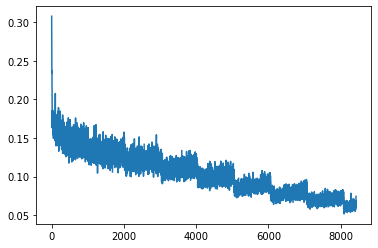

In [ ]:
for i in range(len(loss)):
  loss[i] = loss[i].detach().item()
plt.plot(loss)
# loss

In [ ]:
def evaluate(encoder, decoder, input_variable, lengths, max_length=11, device='cpu'):
    decoder_input = torch.tensor([1], dtype=torch.long).reshape(1, 1)
    encoder_output, encoder_hidden = encoder(input_variable, lengths)
    # decoder_hidden = repeat(encoder_hidden[-1], 'b h -> n b h', n=decoder.n_layers)
    decoder_hidden = encoder_hidden[-decoder.n_layers:]
    print(encoder_output.shape, decoder_hidden.shape)

    out_token = []
    for i in range(max_length):
        decoder_ouput, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)
        out_token.append(torch.argmax(decoder_ouput, dim=1))
        decoder_input = torch.argmax(decoder_ouput, dim=1).reshape(1, 1)
           
       
       

    
    return out_token

encoder.eval().cpu()
decoder.eval().cpu()


LuongAttnDecoderRNN(
  (embedding): Embedding(26943, 500)
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=1000, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=26943, bias=True)
  (attn): Attn()
)

In [ ]:
word = 'can we fuck together'


word_tensor = torch.tensor([vocab.word2idx[i] for i in word.split()] +  [2],dtype=torch.long)
# if len(word.split()) < 11:
#           word_tensor = torch.cat([word_tensor, torch.zeros(10 - len(word.split()), dtype=torch.long)])
word_tensor = word_tensor.reshape(-1, 1)
out_token = evaluate(encoder, decoder, word_tensor, torch.tensor([len(word.split()) + 1]))
sentence = ''
for i in out_token:
    sentence += vocab.idx2word[i.item()] + ' '
sentence

torch.Size([5, 1, 500]) torch.Size([2, 1, 500])


'im not sure EOS EOS EOS EOS EOS EOS EOS EOS '